In [1]:
import numpy as np
import cv2
import glob
%matplotlib inline

In [ ]:
!echo $PYTHONPATH

/env/python


Ensuring Sci-Kit version in Colab matches with my local machine. Throws a lot of errors if not.

In [2]:
!pip install scikit-learn==0.23.1

     |████████████████████████████████| 6.9MB 4.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import sklearn
print(sklearn.__version__)

0.23.1


Accessing images from GDrive directly is a time consuming task considering the amount of files I'm going to access. Saving the numpy format in pickle file for later use

In [ ]:
vehicles_dir =     '/content/drive/My Drive/Project/Data/DL/vehicles/vehicles/**/*.png'
non_vehicles_dir = '/content/drive/My Drive/Project/Data/DL/non-vehicles/**/*.png'
# images are divided up into vehicles and non-vehicles
vehicles = []
nonvehicles = []

In [ ]:
vehicles_frames = glob.glob(vehicles_dir , recursive=True)
print(len(vehicles_frames))
for i in range(len(vehicles_frames)):
    if i%200 == 0:
      print(i)
    frame = cv2.imread(vehicles_frames[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    vehicles.append(frame)
print(len(vehicles))

8792
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8792


In [ ]:
non_vehicles_frames = glob.glob(non_vehicles_dir , recursive=True)
print(len(non_vehicles_frames))
for i in range(len(non_vehicles_frames)):
    if i%200 == 0:
      print(i)
    frame = cv2.imread(non_vehicles_frames[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    nonvehicles.append(frame)
print(len(nonvehicles))

8978
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
8978


In [ ]:
import pickle
save_path = '/content/drive/My Drive/Project/detection_data.p'
with open(save_path, 'wb') as file:
    pickle.dump(
        {'vehicles': vehicles,
         'nonvehicles': nonvehicles
        },
        file, pickle.HIGHEST_PROTOCOL)

In [ ]:
assert True==False

In [2]:
import pickle
pickle_file = '/content/drive/My Drive/Project/detection_data.p'

with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
    vehicles = data['vehicles']
    nonvehicles = data['nonvehicles']
    del data
    
print("Vehicles =", len(vehicles)) 
print("Non-Vehicles =", len(nonvehicles))

Vehicles = 8792
Non-Vehicles = 8978


# **Helper functions for visualisation**

In [3]:
import random
import matplotlib.pyplot as plt

def get_random(data):
  pos = random.randint(0,len(data))
  print(pos)
  return data[pos]

def sample_canvas(data,title):
  fig,ax = plt.subplots(2,5, figsize=(20,5))
  for i in range(2):
      for j in range(5):
        ax[i,j].imshow(get_random(data))
  fig.suptitle(title, fontsize=16)
  plt.show()

def plot_channel_histograms(frame,channel_name_list):
  fig,ax = plt.subplots(1,4,figsize=(16,4))
  ax[0].imshow(frame)
  for i in range(3):
    ax[i+1].hist(frame[:,:,i],20,[0,256]);
    ax[i+1].set_title(channel_name_list[i]) 
  plt.show()

def get_check_data(data):
  check_data=[]
  check_data_meta=[]
  check_data.append(data) 
  check_data_meta.append(('R','G','B'))
  check_data.append(cv2.cvtColor(data,cv2.COLOR_RGB2YUV)) 
  check_data_meta.append(('Y','U','V'))
  check_data.append(cv2.cvtColor(data, cv2.COLOR_RGB2LUV))  
  check_data_meta.append(('L','U','V'))
  check_data.append(cv2.cvtColor(data, cv2.COLOR_RGB2HSV))  
  check_data_meta.append(('H','S','V'))
  check_data.append(cv2.cvtColor(data, cv2.COLOR_RGB2HLS))  
  check_data_meta.append(('H','L','S'))
  check_data.append(cv2.cvtColor(data, cv2.COLOR_RGB2YCrCb))
  check_data_meta.append(('Y','Cr','Cb'))

  return check_data,check_data_meta


# **Sampling if the variables are correctly loaded**


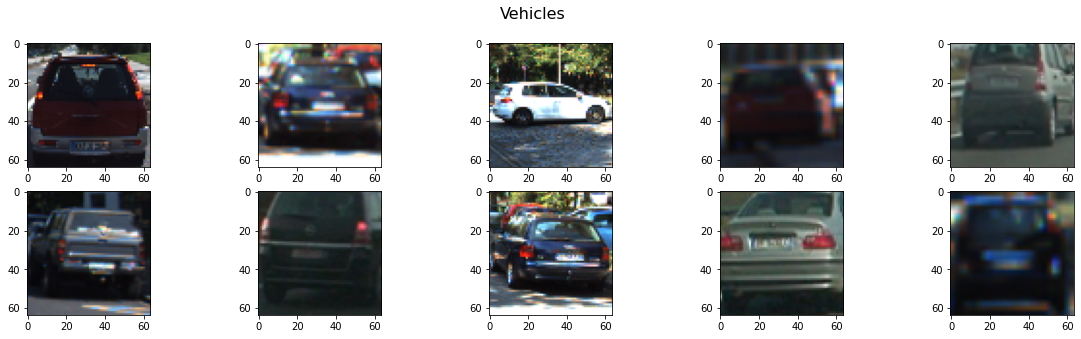

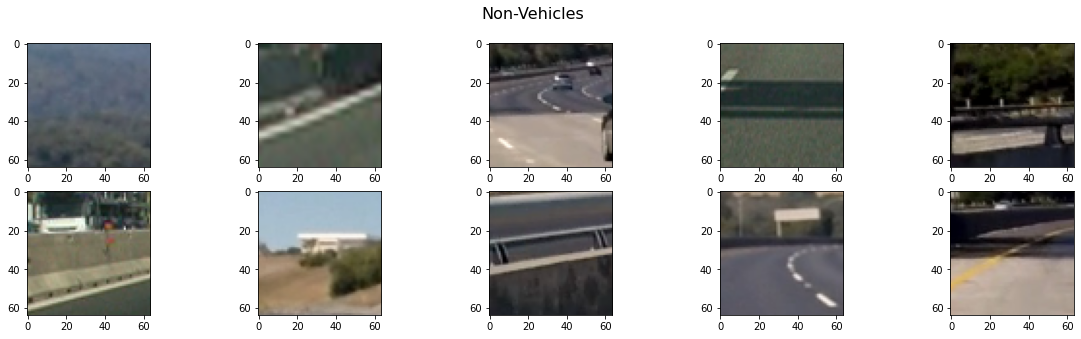

In [ ]:
sample_canvas(vehicles,"Vehicles")
sample_canvas(nonvehicles,"Non-Vehicles")

# **Historam variation from different color channels**

---

Identifying variation patterns in vehicle and non_vehicles specific to color channels 

717
4452


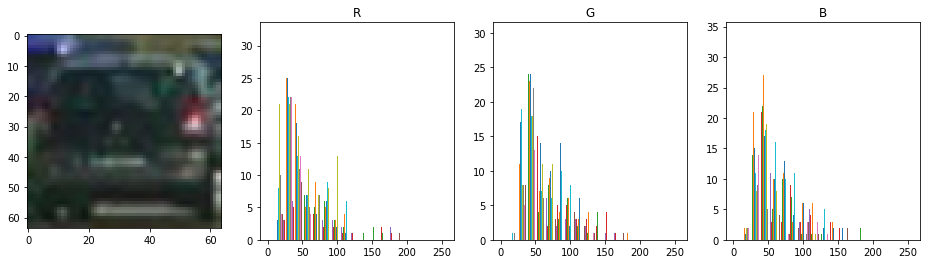

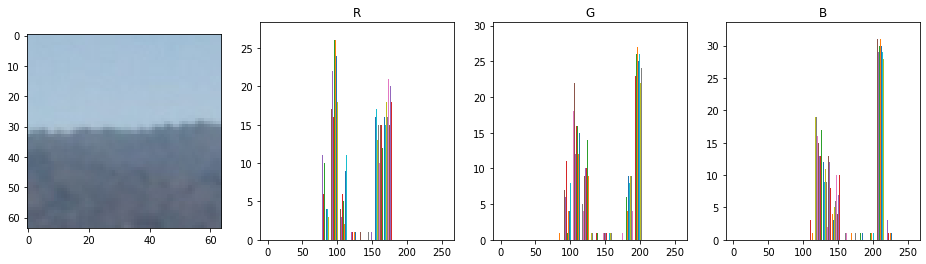

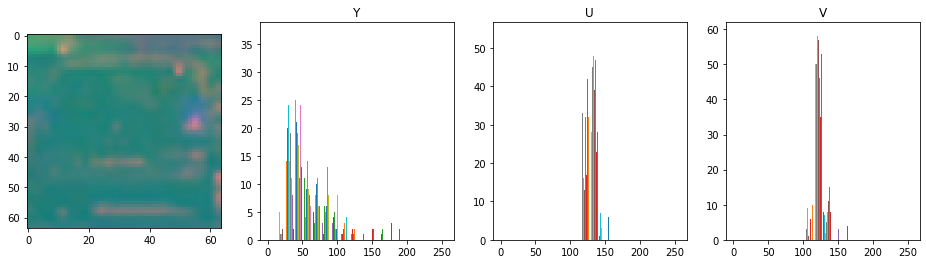

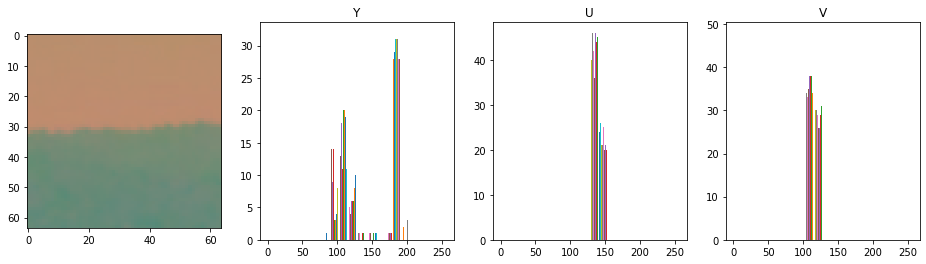

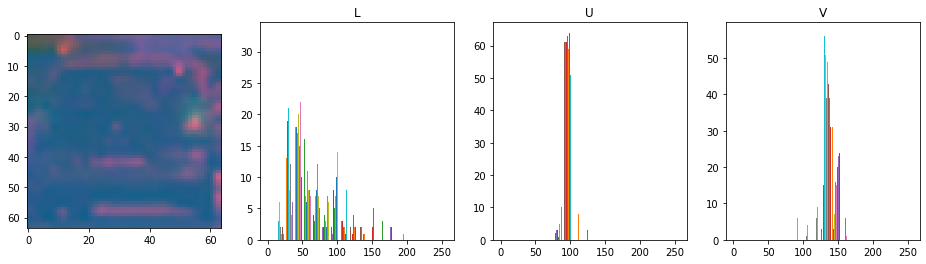

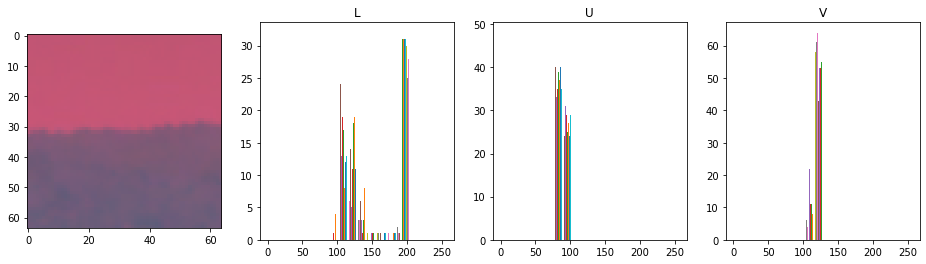

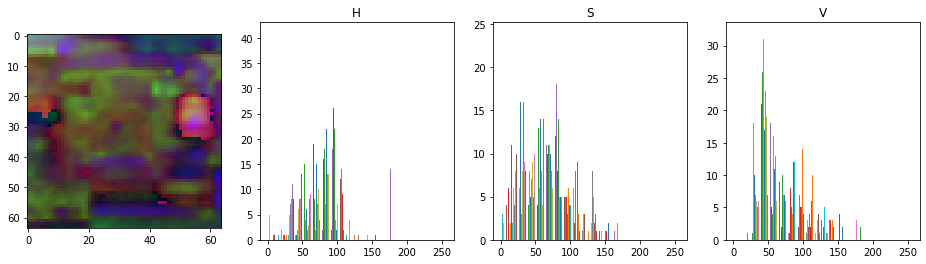

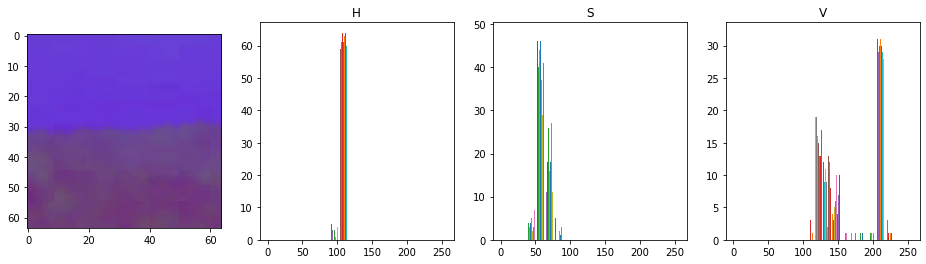

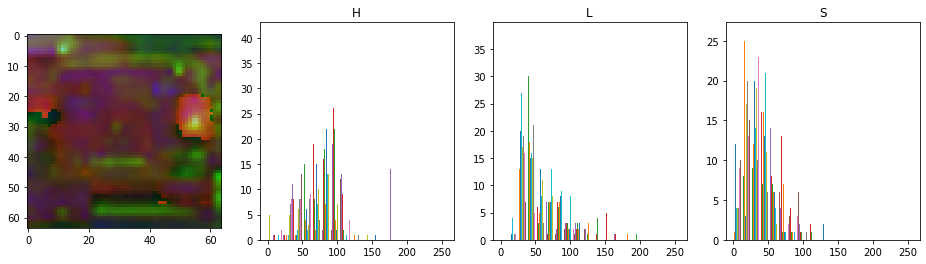

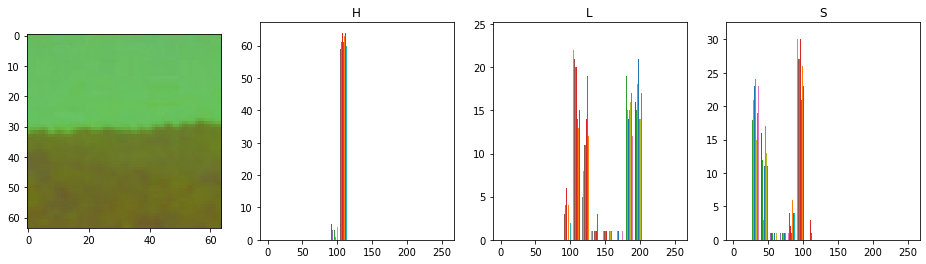

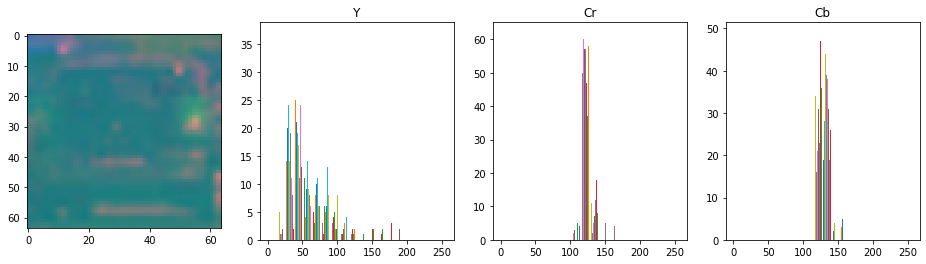

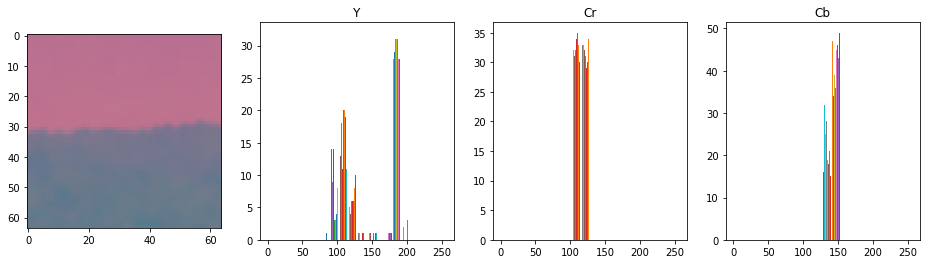

In [ ]:
random_vehicle = get_random(vehicles)
random_non_vehicle =get_random(nonvehicles)

c_data, c_data_meta = get_check_data(random_vehicle)
c_data1, c_data_meta1 = get_check_data(random_non_vehicle)

for i in range(len(c_data)):
  plot_channel_histograms(c_data[i],c_data_meta[i])
  plot_channel_histograms(c_data1[i],c_data_meta1[i])

# **Helper Functions for feature extraction**

In [4]:
from skimage.feature import hog
def get_hog_features(frame, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False, feature_vector=True, multichannel=None):
    normalized_blocks = []
    if visualize:
        normalized_blocks, hog_image = hog(
            frame[:, :, channel], orientations, pixels_per_cell, cells_per_block, visualize=visualize, feature_vector=feature_vector)
        return normalized_blocks, hog_image
    else:
        for channel in range(frame.shape[2]):
            normalized_blocks.append(hog(frame[:, :, channel], orientations, pixels_per_cell,
                                         cells_per_block, visualize=visualize, feature_vector=feature_vector))
        normalized_blocks = np.ravel(normalized_blocks)
        return normalized_blocks

def get_other_features(frame):
    rs_bins = []
    sf_hist = []
    for i in range(3):
        rs_bins.append(cv2.resize(frame[:, :, i], (32, 32)).ravel())
        sf_hist.append(np.histogram(frame[:,:,i], bins=32))
    rs_bins = np.concatenate((rs_bins[0], rs_bins[1], rs_bins[2]))
    sf_hist = np.concatenate((sf_hist[0][0], sf_hist[1][0], sf_hist[2][0]))
    
    return rs_bins,sf_hist

def get_complete_features(frame,ori=15,ppc=8,cpb=2):
   feat=[]
   normalized_blocks = get_hog_features(frame,ori,(ppc,ppc),(cpb,cpb))
   rs_bins,sf_hist = get_other_features(frame)
   stacked = np.hstack((rs_bins, sf_hist, normalized_blocks)).reshape(-1)
   return stacked

# **Extracting Features for MODEL A approach**

In [23]:
vehicle_feat=[]
non_vehicle_feat=[]
for vehicle in vehicles:
  vehicle_feat.append(get_complete_features(vehicle))
for nonvehicle in nonvehicles:
  non_vehicle_feat.append(get_complete_features(nonvehicle))

In [26]:
print(len(vehicle_feat[0]))

11988


In [27]:
X = np.vstack((vehicle_feat, non_vehicle_feat)).astype(np.float64)
y = np.hstack((np.ones(len(vehicle_feat)), np.zeros(len(non_vehicle_feat))))
print(X.shape,y.shape)

(17770, 11988) (17770,)


In [ ]:
validate_zeros= y[y==0]
validate_ones = y[y==1]
print(validate_zeros.shape,validate_ones.shape)

(8978,) (8792,)


In [31]:
from sklearn.preprocessing import StandardScaler
X = np.vstack((vehicle_feat, non_vehicle_feat)).astype(np.float64)                        
scaler_feat = StandardScaler().fit(X)
trans_X = scaler_feat.transform(X)

In [41]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    trans_X, y, test_size=0.2, random_state=rand_state)

In [42]:
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=100000,dual=True)
svc.fit(X_train, y_train)

LinearSVC(max_iter=100000)

In [43]:
print("Accuracy is",svc.score(X_test, y_test))

Accuracy is 0.9870568373663478


## **Saving models in pickle for future use**

In [ ]:
import pickle
import os
data_file = '/content/drive/My Drive/Project/svmhopeful.p'
with open(data_file, 'wb') as pfile:
    pickle.dump(svc,
        pfile, pickle.HIGHEST_PROTOCOL)
data_file = '/content/drive/My Drive/Project/xscalerhopeful.p'
with open(data_file, 'wb') as pfile:
    pickle.dump(scaler_feat,
        pfile, pickle.HIGHEST_PROTOCOL)
print('Done')

# **Extracting Features for MODEL B approach**

In [5]:
vehicle_feat_B=[]
non_vehicle_feat_B=[]
for vehicle in vehicles:
  vehicle_feat_B.append(get_hog_features(vehicle))
for nonvehicle in nonvehicles:
  non_vehicle_feat_B.append(get_hog_features(nonvehicle))

In [7]:
X_B = np.vstack((vehicle_feat_B, non_vehicle_feat_B)).astype(np.float64)
y_B = np.hstack((np.ones(len(vehicle_feat_B)), np.zeros(len(non_vehicle_feat_B))))
print(X_B.shape,y_B.shape)

(17770, 972) (17770,)


In [9]:
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_B, test_size=0.20, random_state=rand_state,stratify=y_B)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [11]:
assert True == False

AssertionError: 

In [12]:
import warnings
warnings.filterwarnings('ignore')

## **Tuning Hyperparameters**

In [51]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]

scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(SVC(), tuned_parameters, cv=4,scoring='%s_macro' % score, verbose=3)
    clf.fit(X_train1, y_train1)
    print("Best parameters:")
    print()
    print(clf.best_params_)
    print()
    print("Best Estimator:")
    print()
    print(clf.best_estimator_)
    print()

# Tuning hyper-parameters for precision

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.253, total= 4.5min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.253, total= 4.5min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.9min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.253, total= 4.5min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.253, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.253, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.253, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.253, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.253, total= 4.4min
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] ... C=0.001, gamma=0.0001, kernel=rbf, score=0.253, total= 4.4min
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 297.6min finished


Best parameters:

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

Best Estimator:

SVC(C=1000, gamma=0.01)

# Tuning hyper-parameters for recall

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.8min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .... C=0.001, gamma=0.001, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] ... C=0.001, gamma=0.0001, kernel=rbf, score=0.500, total= 4.4min
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 297.4min finished


Best parameters:

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

Best Estimator:

SVC(C=1000, gamma=0.01)



In [13]:
svc = SVC(C= 1000, gamma= 0.01, kernel= 'rbf',probability=True)
svc.fit(X_train_B, y_train_B)

SVC(C=1000, gamma=0.01, probability=True)

In [14]:
print("Accuracy is",svc.score(X_test_B, y_test_B))

Accuracy is 0.9909960607765897


In [ ]:
assert True == False

## **Saving models in pickle for future use**

In [ ]:
import os
pickle_file = '/content/drive/My Drive/Project/svc_hope.p'

if not os.path.isfile(pickle_file):
    with open(pickle_file, 'wb') as file:
        pickle.dump(svc,
            file, pickle.HIGHEST_PROTOCOL)